In [1]:
import cartopy
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib as mpl

In [2]:
pr_forcing = xa.open_dataarray("../gridMET/Rocky/pr_1980_2018.nc")
print("FORCING: ")
print(pr_forcing.time)
pr_forcing = pr_forcing.sel(time=slice("2008-10-01", "2018-09-30"))

FORCING: 
<xarray.DataArray 'time' (time: 14245)>
array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31


# Scaler

In [3]:
import sys

sys.path.insert(0, "/tempest/duan0000/SWE/data")

from SWE_Dataset import gridMETDatasetStation

In [4]:
forcings = {"pr": "../gridMET/pr_wus.nc"}
attributions = ["longitude", "latitude", "elevation_prism", "dah", "trasp"]
ds = gridMETDatasetStation(
    forcings=forcings,
    mode="TRAIN",
    window_size=180,
    attributions=attributions,
    target=["SWE"],
    station_id=0,
    topo_file="../SNOTEL/raw_wus_snotel_topo_clean.nc",
)
attr = xa.open_dataset("../SNOTEL/raw_wus_snotel_topo_clean.nc")
y = attr["SWE"]
y = y.sel(time=slice("1980-10-01", "1999-09-30"))
print(y)
print(y.mean(skipna=True))
print(y.std(skipna=True))
print(ds.target_mean)
print(ds.target_std)

<xarray.DataArray 'SWE' (n_stations: 581, time: 6939)>
[4031559 values with dtype=float64]
Coordinates:
  * n_stations  (n_stations) int64 0 2 3 4 6 7 8 ... 822 823 824 825 826 827 828
  * time        (time) datetime64[ns] 1980-10-01 1980-10-02 ... 1999-09-30
<xarray.DataArray 'SWE' ()>
array(6.7269426)
<xarray.DataArray 'SWE' ()>
array(10.55761453)
6.72694260394129
10.557614530114346


# NSIDC

In [5]:
prediction = np.load("LSTM_clean_lats/prediction_0.npy")
print(prediction.shape)
lstm_ori = np.zeros(prediction.shape)
lstm_ori+=prediction
for i in range(1, 10):
    prediction = np.load('LSTM_clean_lats/prediction_'+str(i)+'.npy')
    lstm_ori+=prediction
lstm_ori = lstm_ori/10
lstm_ori = xa.DataArray(
    lstm_ori,
    dims=["lat", "lon", "time"],
    coords={"lat": pr_forcing.lat, "lon": pr_forcing.lon, "time": pr_forcing.time[-3473:]},
)
print(lstm_ori.time)

(168, 108, 3473)
<xarray.DataArray 'time' (time: 3473)>
array(['2009-03-29T00:00:00.000000000', '2009-03-30T00:00:00.000000000',
       '2009-03-31T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-29 2009-03-30 ... 2018-09-30


In [6]:
nsidc = xa.open_dataarray("../co_prediction/SWES_NSIDC_all.nc")
nsidc = nsidc.sel(time=slice(lstm_ori.time[0], lstm_ori.time[-1]))
nsidc = nsidc.reindex(lat=nsidc.lat[::-1])
print(nsidc.shape)
print(nsidc.time)
nsidc_lon = nsidc.lon.data
nsidc_lat = nsidc.lat.data

(3473, 167, 107)
<xarray.DataArray 'time' (time: 3473)>
array(['2009-03-29T00:00:00.000000000', '2009-03-30T00:00:00.000000000',
       '2009-03-31T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-29 2009-03-30 ... 2018-09-30
Attributes:
    long_name:  time


In [7]:
nsidc_hist = xa.open_dataarray("../NSIDC/SWES_NSIDC_hist.nc")
nsidc_hist = nsidc_hist.reindex(lat=nsidc_hist.lat[::-1])
nsidc_hist_max = nsidc_hist.max(dim='time', skipna=True)

/tempest/duan0000/anaconda3/envs/pytorch/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [8]:
def calculate(ori, relative):
    r2 = np.empty((167, 107))
    r2[:] = np.NAN
    for i in range(167):
        for j in range(107):
            true = nsidc[:, i, j] / 25.4  # mm to inch
            pred = (ori[i + 1, j + 1, :] * ds.target_std) + ds.target_mean
            if np.count_nonzero(np.isnan(true)) > 0:
                ind = np.where(np.isnan(true))[0]
                true = np.delete(true, ind)
                pred = np.delete(pred, ind)
                # print(i, j)
            if len(true) == 0:
                pass
            else:
                r2[i, j] = r2_score(true, pred)
    
    r2_relative_snow = np.empty((167, 107))
    r2_relative_snow[:] = np.NAN
    for i in range(167):
        for j in range(107):
            true = nsidc[:, i, j] / 25.4  # mm to inch
            pred = relative[i + 1, j + 1, :]
            if np.count_nonzero(np.isnan(true)) > 0:
                ind = np.where(np.isnan(true))[0]
                true = np.delete(true, ind)
                pred = np.delete(pred, ind)
                # print(i, j)
            if len(true) == 0 or np.isnan(nsidc_hist_max[i, j]):
                pass
            else:
                pred = pred*nsidc_hist_max[i, j]/25.4
                r2_relative_snow[i, j] = r2_score(true, pred)
    return r2, r2_relative_snow

In [9]:
def plot_r2(r2):
    norm = colors.Normalize(vmin=-1, vmax=1)
    r2[r2<-1]=np.NAN
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
    ax.contourf(nsidc_lon, nsidc_lat, r2, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm')
    ax.add_feature(cartopy.feature.STATES, alpha=0.9)
    divider = make_axes_locatable(ax)
    cax1 = divider.new_vertical(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=True)
    fig.add_axes(cax1)
    fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap="coolwarm"),
        cax=cax1,
        orientation="horizontal",
    )
    plt.show()

# LSTM

In [10]:
prediction = np.load("LSTM_relative_clean_lats/prediction_0.npy")
print(prediction.shape)
lstm_rel = np.zeros(prediction.shape)
lstm_rel+=prediction
for i in range(1, 10):
    prediction = np.load('LSTM_relative_clean_lats/prediction_'+str(i)+'.npy')
    lstm_rel+=prediction
lstm_rel = lstm_rel/10
lstm_rel = xa.DataArray(
    lstm_rel,
    dims=["lat", "lon", "time"],
    coords={"lat": pr_forcing.lat, "lon": pr_forcing.lon, "time": pr_forcing.time[-3473:]},
)

(168, 108, 3473)


In [11]:
r2_lstm, r2_relative_lstm = calculate(lstm_ori, lstm_rel)

/tempest/duan0000/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


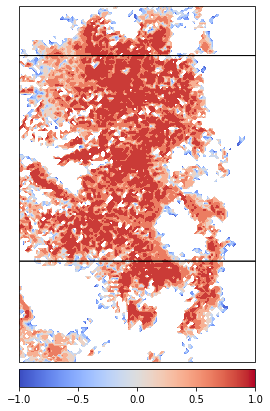

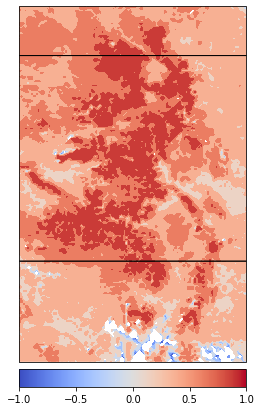

In [12]:
plot_r2(r2_lstm)
plot_r2(r2_relative_lstm)

# TCNN

In [13]:
prediction = np.load("TCNN_clean_lats/prediction_0.npy")
print(prediction.shape)
tcnn_ori = np.zeros(prediction.shape)
tcnn_ori+=prediction
for i in range(1, 10):
    prediction = np.load('TCNN_clean_lats/prediction_'+str(i)+'.npy')
    tcnn_ori+=prediction
tcnn_ori = tcnn_ori/10
tcnn_ori = xa.DataArray(
    tcnn_ori,
    dims=["lat", "lon", "time"],
    coords={"lat": pr_forcing.lat, "lon": pr_forcing.lon, "time": pr_forcing.time[-3473:]},
)
print(tcnn_ori.time)

(168, 108, 3473)
<xarray.DataArray 'time' (time: 3473)>
array(['2009-03-29T00:00:00.000000000', '2009-03-30T00:00:00.000000000',
       '2009-03-31T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-29 2009-03-30 ... 2018-09-30


In [14]:
prediction = np.load("TCNN_relative_clean_lats/prediction_0.npy")
print(prediction.shape)
tcnn_rel = np.zeros(prediction.shape)
tcnn_rel+=prediction
for i in range(1, 10):
    prediction = np.load('TCNN_relative_clean_lats/prediction_'+str(i)+'.npy')
    tcnn_rel+=prediction
tcnn_rel = tcnn_rel/10
tcnn_rel = xa.DataArray(
    tcnn_rel,
    dims=["lat", "lon", "time"],
    coords={"lat": pr_forcing.lat, "lon": pr_forcing.lon, "time": pr_forcing.time[-3473:]},
)
print(tcnn_rel.time)

(168, 108, 3473)
<xarray.DataArray 'time' (time: 3473)>
array(['2009-03-29T00:00:00.000000000', '2009-03-30T00:00:00.000000000',
       '2009-03-31T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-29 2009-03-30 ... 2018-09-30


In [15]:
r2_tcnn, r2_relative_tcnn = calculate(tcnn_ori, tcnn_rel)

/tempest/duan0000/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


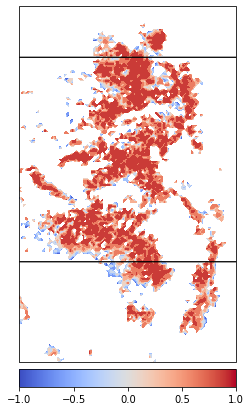

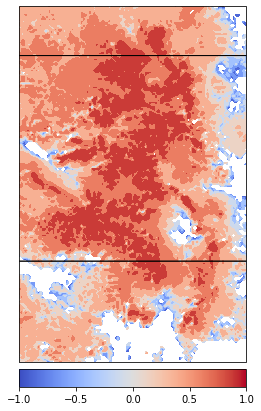

In [16]:
plot_r2(r2_tcnn)
plot_r2(r2_relative_tcnn)

# Attention

In [17]:
prediction = np.load("Attention_clean_lats/prediction_0.npy")
print(prediction.shape)
att_ori = np.zeros(prediction.shape)
att_ori+=prediction
for i in range(1, 10):
    prediction = np.load('Attention_clean_lats/prediction_'+str(i)+'.npy')
    att_ori+=prediction
att_ori = att_ori/10
att_ori = xa.DataArray(
    att_ori,
    dims=["lat", "lon", "time"],
    coords={"lat": pr_forcing.lat, "lon": pr_forcing.lon, "time": pr_forcing.time[-3473:]},
)
print(att_ori.time)

(168, 108, 3473)
<xarray.DataArray 'time' (time: 3473)>
array(['2009-03-29T00:00:00.000000000', '2009-03-30T00:00:00.000000000',
       '2009-03-31T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-29 2009-03-30 ... 2018-09-30


In [18]:
prediction = np.load("Attention_relative_clean_lats/prediction_9.npy")
print(prediction.shape)
att_rel = np.zeros(prediction.shape)
att_rel+=prediction
for i in range(1, 10):
    prediction = np.load('Attention_relative_clean_lats/prediction_'+str(i)+'.npy')
    att_rel+=prediction
att_rel = att_rel/10
att_rel = xa.DataArray(
    att_rel,
    dims=["lat", "lon", "time"],
    coords={"lat": pr_forcing.lat, "lon": pr_forcing.lon, "time": pr_forcing.time[-3473:]},
)
print(att_rel.time)

(168, 108, 3473)
<xarray.DataArray 'time' (time: 3473)>
array(['2009-03-29T00:00:00.000000000', '2009-03-30T00:00:00.000000000',
       '2009-03-31T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-29 2009-03-30 ... 2018-09-30


In [19]:
r2_att, r2_relative_att = calculate(att_ori, att_rel)

/tempest/duan0000/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


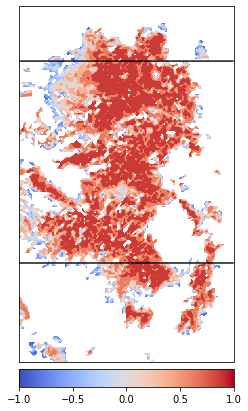

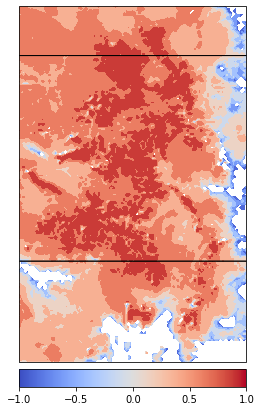

In [21]:
plot_r2(r2_att)
plot_r2(r2_relative_att)

# All models

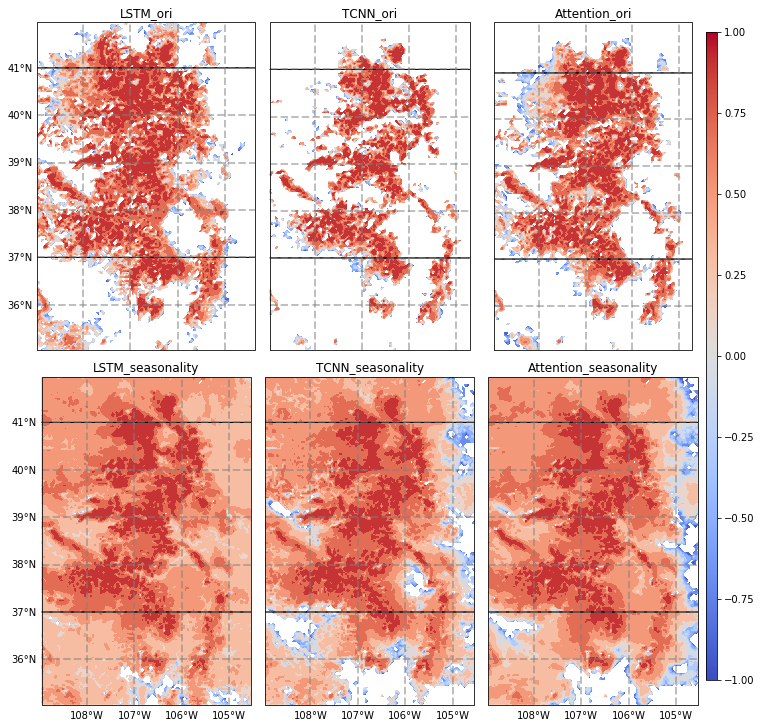

In [22]:
norm = colors.Normalize(vmin=-1, vmax=1)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231, projection=cartopy.crs.PlateCarree())
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
ax1.contourf(nsidc_lon, nsidc_lat, r2_lstm, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=10)
ax1.add_feature(cartopy.feature.STATES, alpha=0.9)
ax1.set_title('LSTM_ori', fontsize=12)

ax2 = fig.add_subplot(232, projection=cartopy.crs.PlateCarree())
ax2.contourf(nsidc_lon, nsidc_lat, r2_tcnn, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=10)
ax2.add_feature(cartopy.feature.STATES, alpha=0.9)
gl = ax2.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.top_labels = False
gl.left_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
ax2.set_title('TCNN_ori', fontsize=12)

ax3 = fig.add_subplot(233, projection=cartopy.crs.PlateCarree())
gl = ax3.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.top_labels = False
gl.left_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
ax3.contourf(nsidc_lon, nsidc_lat, r2_att, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=10)
ax3.add_feature(cartopy.feature.STATES, alpha=0.9)
ax3.set_title('Attention_ori', fontsize=12)

ax7 = fig.add_subplot(234, projection=cartopy.crs.PlateCarree())
gl = ax7.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels=True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
ax7.contourf(nsidc_lon, nsidc_lat, r2_relative_lstm, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=10)
ax7.add_feature(cartopy.feature.STATES, alpha=0.9)
ax7.set_title('LSTM_seasonality', fontsize=12)

ax6 = fig.add_subplot(235, projection=cartopy.crs.PlateCarree())
gl = ax6.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.right_labels = False
gl.bottom_labels=True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
ax6.contourf(nsidc_lon, nsidc_lat, r2_relative_tcnn, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=10)
ax6.add_feature(cartopy.feature.STATES, alpha=0.9)
ax6.set_title('TCNN_seasonality', fontsize=12)

ax6 = fig.add_subplot(236, projection=cartopy.crs.PlateCarree())
gl = ax6.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.right_labels = False
gl.bottom_labels=True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
ax6.contourf(nsidc_lon, nsidc_lat, r2_relative_att, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=10)
ax6.add_feature(cartopy.feature.STATES, alpha=0.9)
ax6.set_title('Attention_seasonality', fontsize=12)

plt.tight_layout()

fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.945, 0.05, 0.015, 0.9])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()